In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-20 13:52:32.220564: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-20 13:52:32.238955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb2cda579c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-20 13:52:32.238969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
def calculate_term(e, c0, c1):
    a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
    b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
    return K.dot(K.transpose(a), b)

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
       p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
              * calculate_term(e, c0[i], c1[i])
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [12]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = []
    for i in range(len(c0)):
         p_loss.append((1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
              * calculate_term(e, c0[i], c1[i]))
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, e, c0, c1), name='ps', aggregation='mean')

In [13]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:2*limit], y_train[limit:2*limit]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 4096 samples, validate on 4096 samples
Epoch 1/200
4096/4096 [==============================] - 52s 13ms/sample - loss: 1.6926 - acc: 0.9235 - cce: 1.4870 - ps: 0.2057 - val_loss: 0.8880 - val_acc: 0.9580 - val_cce: 0.6940 - val_ps: 0.1939
Epoch 2/200
4096/4096 [==============================] - 40s 10ms/sample - loss: 0.6423 - acc: 0.9729 - cce: 0.4712 - ps: 0.1711 - val_loss: 0.5106 - val_acc: 0.9793 - val_cce: 0.3775 - val_ps: 0.1331
Epoch 3/200
4096/4096 [==============================] - 42s 10ms/sample - loss: 0.4069 - acc: 0.9844 - cce: 0.2895 - ps: 0.1174 - val_loss: 0.4037 - val_acc: 0.9840 - val_cce: 0.2929 - val_ps: 0.1108
Epoch 4/200
4096/4096 [==============================] - 40s 10ms/sample - loss: 0.3103 - acc: 0.9878 - cce: 0.2147 - ps: 0.0956 - val_loss: 0.3693 - val_acc: 0.9846 - val_cce: 0.2744 - val_ps: 0.0949
Epoch 5/200
4096/4096 [==============================] - 41s 10ms/sample - loss: 0.2451 - acc: 0.9915 - cce: 0.1641 - ps: 0.0810 - val_loss: 0.3250 

4096/4096 [==============================] - 41s 10ms/sample - loss: 0.0040 - acc: 1.0000 - cce: 0.0013 - ps: 0.0026 - val_loss: 0.3237 - val_acc: 0.9878 - val_cce: 0.3132 - val_ps: 0.0105
Epoch 42/200
4096/4096 [==============================] - 39s 10ms/sample - loss: 0.0048 - acc: 0.9999 - cce: 0.0016 - ps: 0.0031 - val_loss: 0.3420 - val_acc: 0.9871 - val_cce: 0.3301 - val_ps: 0.0119
Epoch 43/200
4096/4096 [==============================] - 39s 10ms/sample - loss: 0.0046 - acc: 1.0000 - cce: 0.0016 - ps: 0.0030 - val_loss: 0.3449 - val_acc: 0.9873 - val_cce: 0.3342 - val_ps: 0.0107
Epoch 44/200
4096/4096 [==============================] - 41s 10ms/sample - loss: 0.0043 - acc: 1.0000 - cce: 0.0013 - ps: 0.0030 - val_loss: 0.3478 - val_acc: 0.9879 - val_cce: 0.3362 - val_ps: 0.0116
Epoch 45/200
4096/4096 [==============================] - 39s 10ms/sample - loss: 0.0042 - acc: 1.0000 - cce: 0.0011 - ps: 0.0030 - val_loss: 0.3337 - val_acc: 0.9877 - val_cce: 0.3228 - val_ps: 0.0109
Epo

Epoch 81/200
4096/4096 [==============================] - 37s 9ms/sample - loss: 0.0016 - acc: 0.9999 - cce: 6.4458e-04 - ps: 9.2104e-04 - val_loss: 0.4726 - val_acc: 0.9870 - val_cce: 0.4622 - val_ps: 0.0105
Epoch 82/200
4096/4096 [==============================] - 41s 10ms/sample - loss: 0.0010 - acc: 1.0000 - cce: 1.4014e-04 - ps: 8.7478e-04 - val_loss: 0.4596 - val_acc: 0.9866 - val_cce: 0.4520 - val_ps: 0.0076
Epoch 83/200
4096/4096 [==============================] - 39s 10ms/sample - loss: 6.8908e-04 - acc: 1.0000 - cce: 1.8030e-04 - ps: 5.0878e-04 - val_loss: 0.4485 - val_acc: 0.9866 - val_cce: 0.4408 - val_ps: 0.0077
Epoch 84/200
4096/4096 [==============================] - 40s 10ms/sample - loss: 6.3450e-04 - acc: 1.0000 - cce: 1.9006e-04 - ps: 4.4444e-04 - val_loss: 0.4936 - val_acc: 0.9862 - val_cce: 0.4855 - val_ps: 0.0081
Epoch 85/200
4096/4096 [==============================] - 43s 10ms/sample - loss: 0.0012 - acc: 1.0000 - cce: 5.7728e-04 - ps: 6.4192e-04 - val_loss: 0.4

4096/4096 [==============================] - 36s 9ms/sample - loss: 3.2894e-04 - acc: 1.0000 - cce: 9.8380e-05 - ps: 2.3056e-04 - val_loss: 0.5217 - val_acc: 0.9860 - val_cce: 0.5145 - val_ps: 0.0072
Epoch 120/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 1.8540e-04 - acc: 1.0000 - cce: 2.5541e-05 - ps: 1.5986e-04 - val_loss: 0.5259 - val_acc: 0.9858 - val_cce: 0.5185 - val_ps: 0.0074
Epoch 121/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 3.0190e-04 - acc: 1.0000 - cce: 3.7159e-05 - ps: 2.6474e-04 - val_loss: 0.5282 - val_acc: 0.9862 - val_cce: 0.5208 - val_ps: 0.0074
Epoch 122/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 6.3746e-04 - acc: 1.0000 - cce: 2.0680e-04 - ps: 4.3066e-04 - val_loss: 0.5317 - val_acc: 0.9866 - val_cce: 0.5234 - val_ps: 0.0083
Epoch 123/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 6.2107e-04 - acc: 1.0000 - cce: 1.4724e-04 - ps: 4.7384e-04 - val_loss: 0.53

4096/4096 [==============================] - 35s 9ms/sample - loss: 5.3119e-04 - acc: 1.0000 - cce: 1.8867e-04 - ps: 3.4252e-04 - val_loss: 0.5617 - val_acc: 0.9844 - val_cce: 0.5549 - val_ps: 0.0068
Epoch 158/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 4.8722e-04 - acc: 1.0000 - cce: 1.9956e-04 - ps: 2.8766e-04 - val_loss: 0.5493 - val_acc: 0.9850 - val_cce: 0.5420 - val_ps: 0.0073
Epoch 159/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 0.0023 - acc: 0.9999 - cce: 0.0018 - ps: 4.3998e-04 - val_loss: 0.5670 - val_acc: 0.9851 - val_cce: 0.5598 - val_ps: 0.0072
Epoch 160/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 1.4823e-04 - acc: 1.0000 - cce: 2.8239e-05 - ps: 1.1999e-04 - val_loss: 0.5651 - val_acc: 0.9844 - val_cce: 0.5581 - val_ps: 0.0070
Epoch 161/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 4.5682e-04 - acc: 1.0000 - cce: 7.9041e-05 - ps: 3.7777e-04 - val_loss: 0.5765 - val

4096/4096 [==============================] - 35s 9ms/sample - loss: 4.0122e-04 - acc: 1.0000 - cce: 4.6027e-05 - ps: 3.5519e-04 - val_loss: 0.6028 - val_acc: 0.9845 - val_cce: 0.5953 - val_ps: 0.0075
Epoch 196/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 1.6729e-04 - acc: 1.0000 - cce: 1.9531e-05 - ps: 1.4776e-04 - val_loss: 0.6049 - val_acc: 0.9842 - val_cce: 0.5978 - val_ps: 0.0071
Epoch 197/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.8825e-04 - acc: 1.0000 - cce: 3.3201e-05 - ps: 1.5505e-04 - val_loss: 0.6087 - val_acc: 0.9838 - val_cce: 0.6018 - val_ps: 0.0069
Epoch 198/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 1.3287e-04 - acc: 1.0000 - cce: 2.0213e-05 - ps: 1.1266e-04 - val_loss: 0.6074 - val_acc: 0.9843 - val_cce: 0.6005 - val_ps: 0.0069
Epoch 199/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 2.9764e-04 - acc: 1.0000 - cce: 1.8192e-05 - ps: 2.7945e-04 - val_loss: 0.61

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


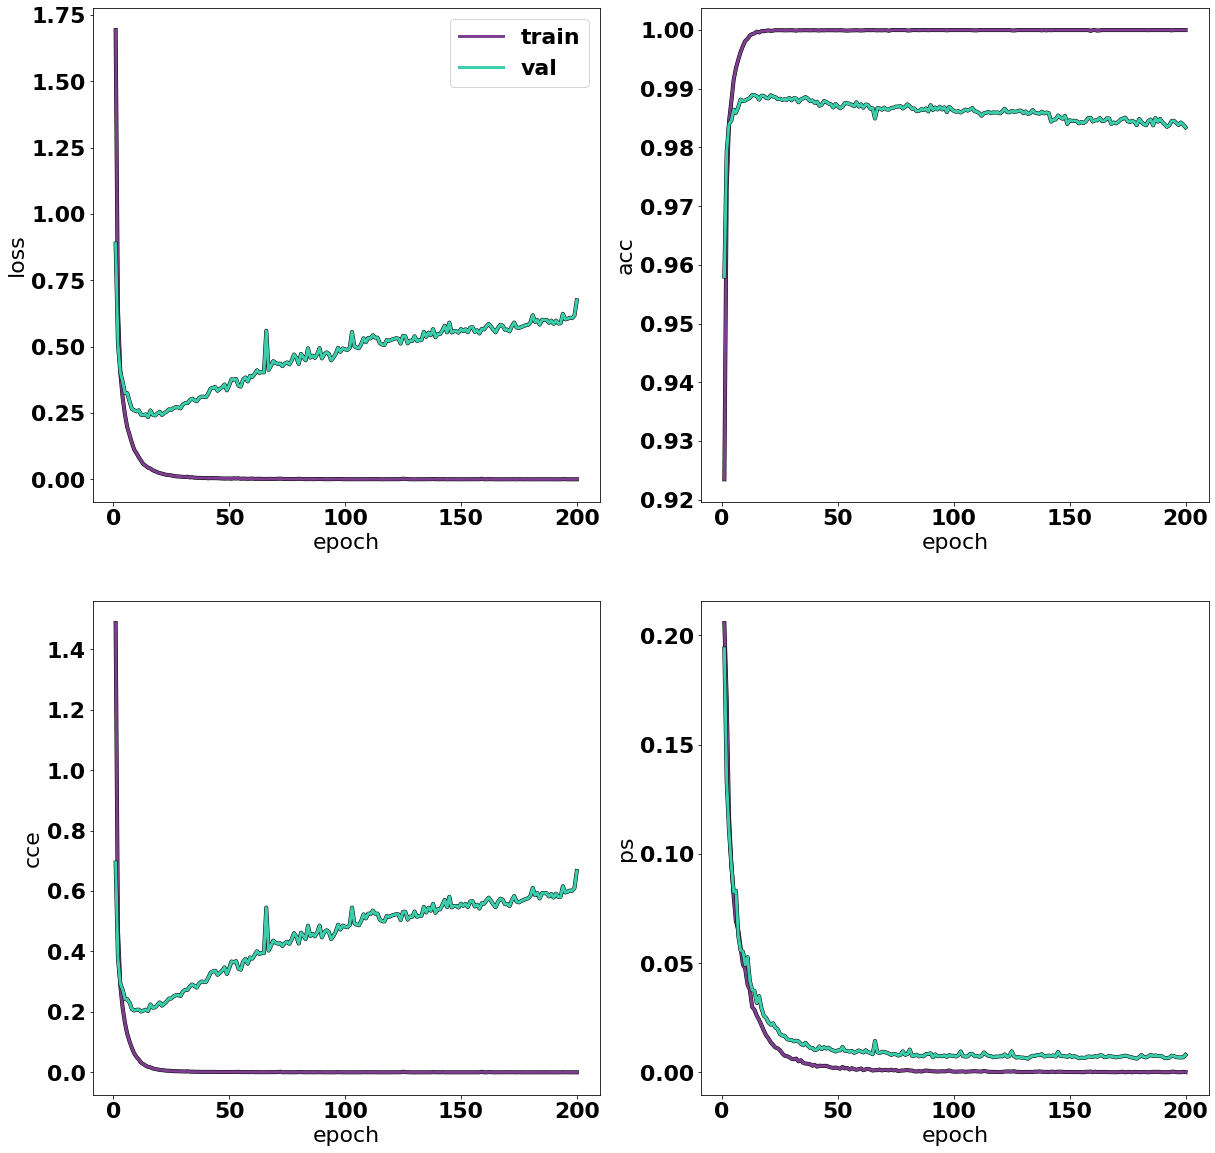

In [14]:
fig = plt.figure(figsize=(20,20))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps']):
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])


### calculate test set accuracy

In [15]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.9826


### calculate activations across the training set

In [16]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [17]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|█████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 1013.77it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


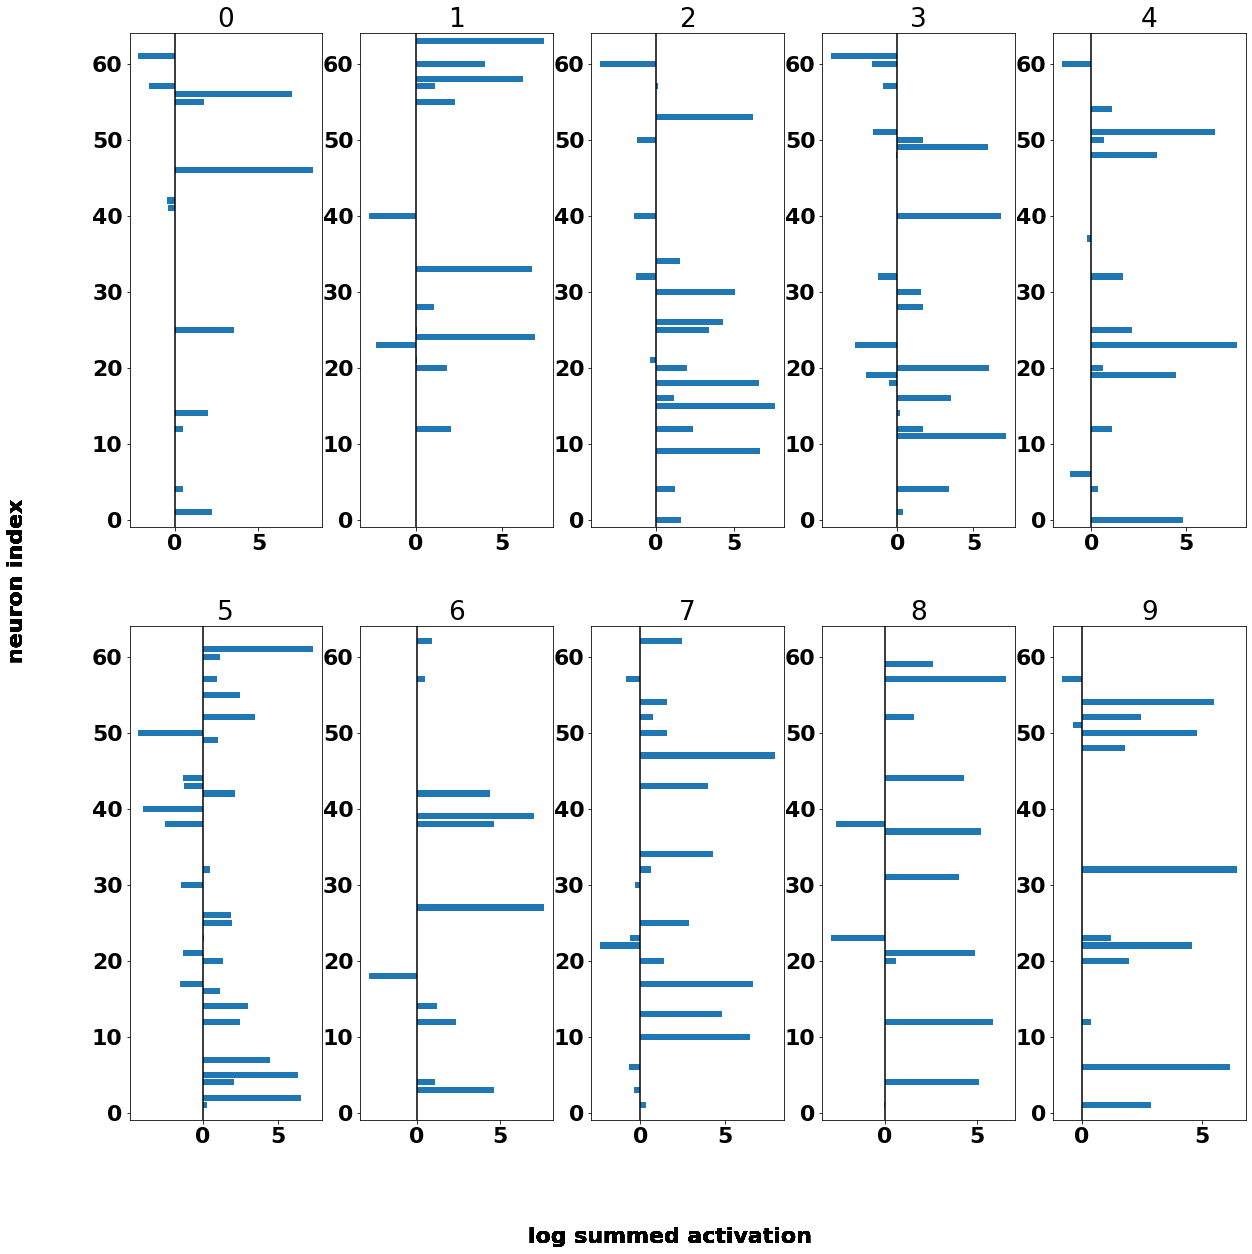

In [18]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [19]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5933.66it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


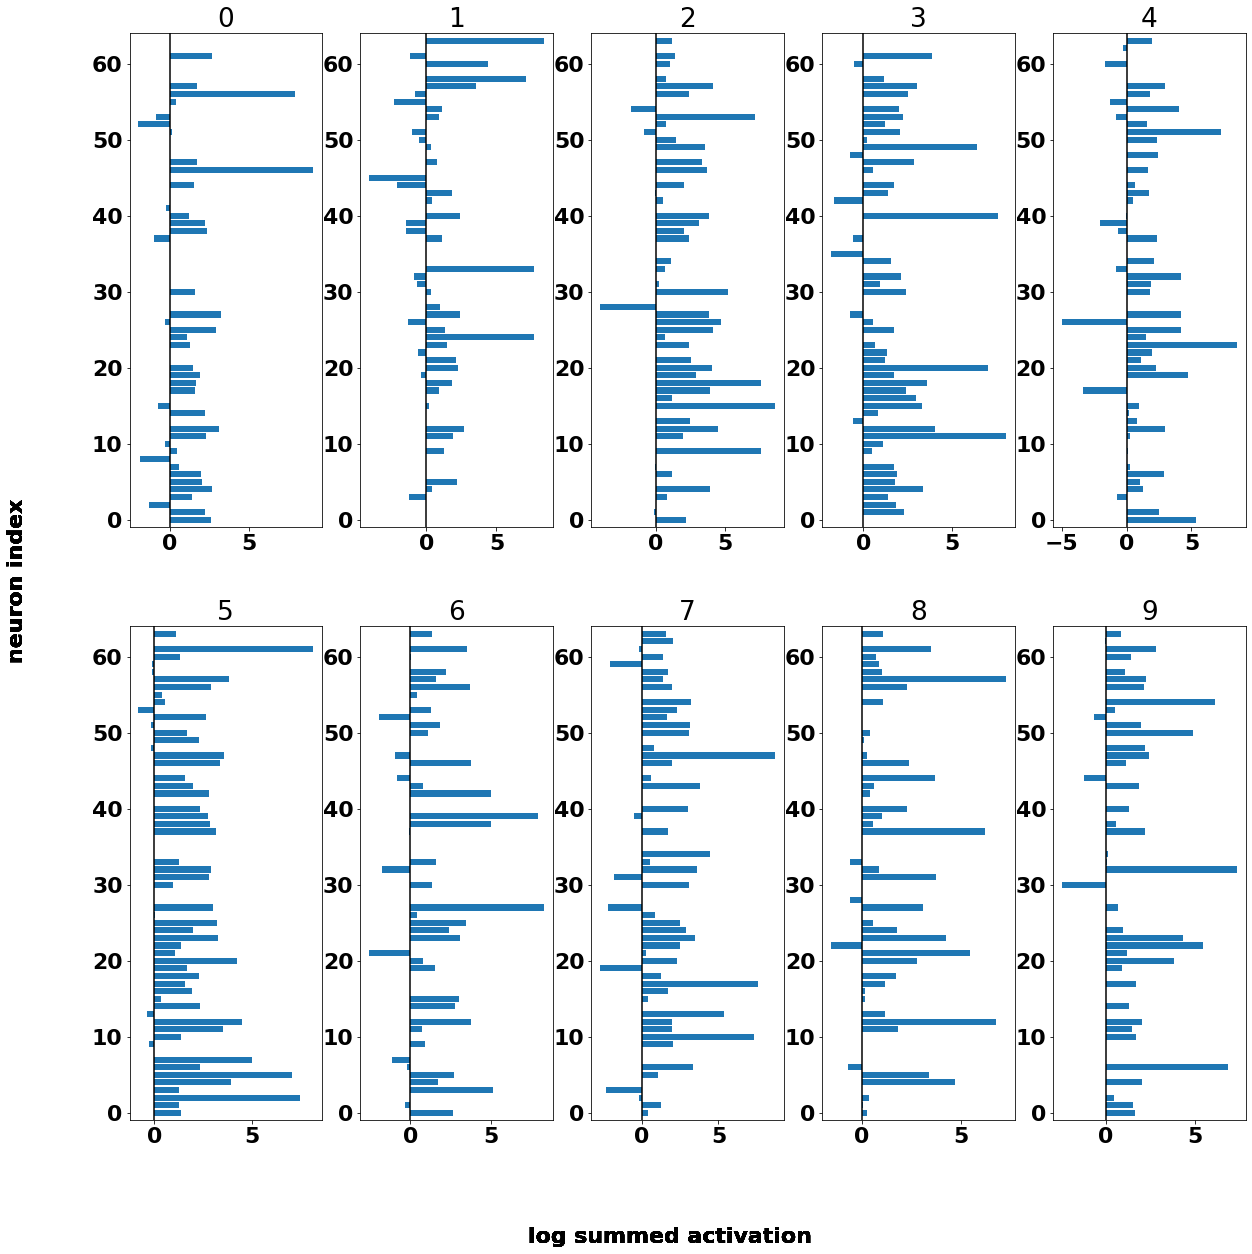

In [20]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [21]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.0012748288137623199


### measure degree of polysemantism across test set activations

In [22]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.014426808005211771


### visualise hidden neurons

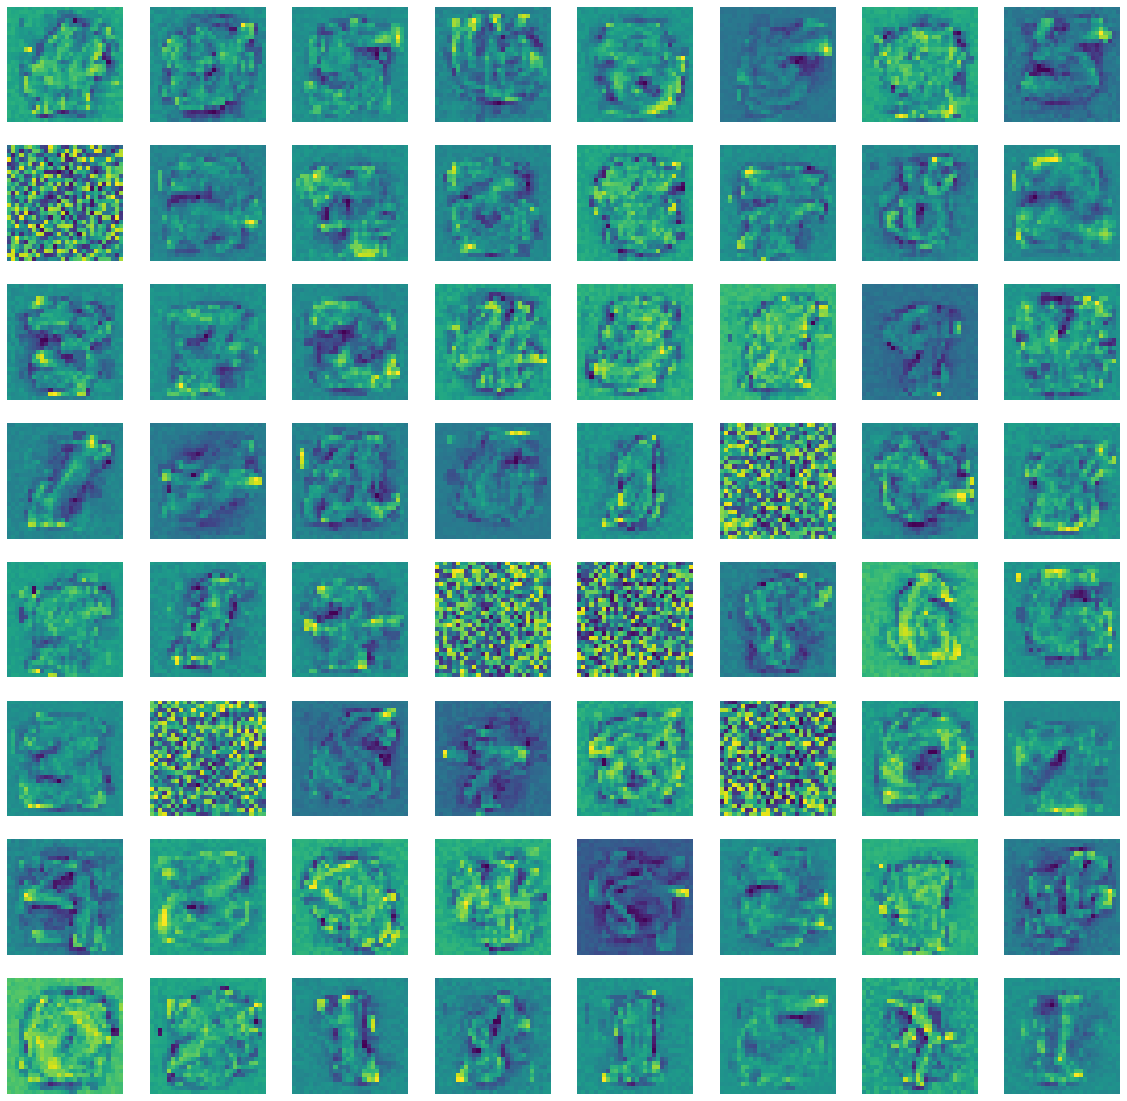

In [23]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()